In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Data Cleaning and Processing

In [2]:
# Data source: https://data.winnipeg.ca/Contact-Centre-311/311-Service-Request/4her-3th5
DF = pd.read_csv("./assets/311_Service_Request.csv")
DF.drop(["Zip Codes", "Location 1", "Wards", "Neighborhoods", "Electoral Ward 2018"], axis=1, inplace=True)
DF["Date"] = DF["Date"].astype('datetime64')
DF
# DF.any(DF["Ward"] == "St. Vital" and )

,Date,Service Area,Service Request,Ward,Neighbourhood,Point
0,2021-03-28 12:35:00,Animal Services,Dog Complaint,St. Vital,Royalwood,POINT (-97.076854696327 49.838635331186)
1,2022-02-11 17:47:00,Water,Water Main Leak,Mynarski,Luxton,POINT (-97.119735644628 49.921935425852)
2,2022-06-15 14:54:00,Street Maintenance,Potholes,St. Vital,Minnetonka,POINT (-97.127578662436 49.822130630891)
3,2022-07-13 13:41:00,Street Maintenance,Potholes,Transcona,Kildare-Redonda,POINT (-96.997967433739 49.905468425712)
4,2022-07-20 08:10:00,Water,Water Main Leak,St. Vital,Varennes,POINT (-97.108356240524 49.858168739189)
...,...,...,...,...,...,...
96309,2021-06-04 11:28:00,Street Maintenance,Potholes,Fort Rouge - East Fort Garry,Crescent Park,POINT (-97.150348958637 49.839795485719)
96310,2022-12-03 03:05:00,By Law Enforcement,Neighbourhood Liveability Complaint,Fort Rouge - East Fort Garry,West Broadway,POINT (-97.158759451893 49.886022451217)
96311,2022-12-30 18:42:00,Street Maintenance,Snow Removal - Roads,St. James,West Wolseley,POINT (-97.19941994246 49.880609195051)
96312,2021-07-26 08:50:00,Street Maintenance,Graffiti,Fort Rouge - East Fort Garry,Broadway-Assiniboine,POINT (-97.134045819738 49.885780710088)


TODO: find which neibourhood have more report in a ward

Ward is easier and simpler

## Services

In [3]:
services = []
for area in DF["Service Area"].unique():
    print(area + ":")
    service_request = DF[DF['Service Area'].str.contains(area)]["Service Request"].unique().tolist()
    services.extend(service_request)
    print(*(service_request), sep="\n")
    print()
    del service_request
    del area

services.sort()

Animal Services:
Dog Complaint

Water:
Water Main Leak

Street Maintenance:
Potholes
Snow Removal - Sidewalks
Graffiti
Snow Removal - Roads
Frozen Catch Basin
Sanding
Sidewalk Repairs
Litter Container Complaint

Sewer & Drainage:
Sewer Backup

Garbage & Recycling:
Missed Garbage Collection
Missed Recycling Collection

By Law Enforcement:
Neighbourhood Liveability Complaint

Insect Control:
Mosquito Complaint
Tree Pest Caterpillar Complaint

Parks and Urban Foresty:
Graffiti
Boulevard Mowing



As shown above, the record currently have these services, divided into areas:

|Animal Services|Water|Street Maintenance|Sewer & Drainage|Garbage & Recycling|By Law Enforcement|Insect Control|Parks and Urban Foresty|
|---|---|---|---|---|---|---|---|
|Dog Complaint|Water Main Leak|Potholes|Sewer Backup|Missed Garbage Collection|Neighbourhood Liveability Complaint|Mosquito Complaint|Graffiti|
|||Snow Removal - Sidewalks||Missed Recycling Collection||Tree Pest Caterpillar Complaint|Boulevard Mowing|
|||Graffiti||||||
|||Snow Removal - Roads||||||
|||Frozen Catch Basin||||||
|||Sanding||||||
|||Sidewalk Repairs||||||
|||Litter Container Complaint||||||

## Neighbourhoods

### Overall distribution among service requests

<AxesSubplot: ylabel='Service Request'>

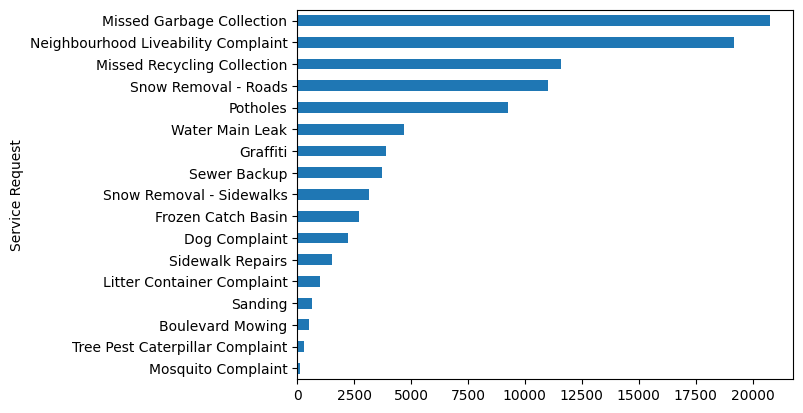

In [4]:
DF.groupby("Service Request").size().sort_values().plot(kind="barh")

### Overall distribution among neighbourhoods

<AxesSubplot: ylabel='Neighbourhood'>

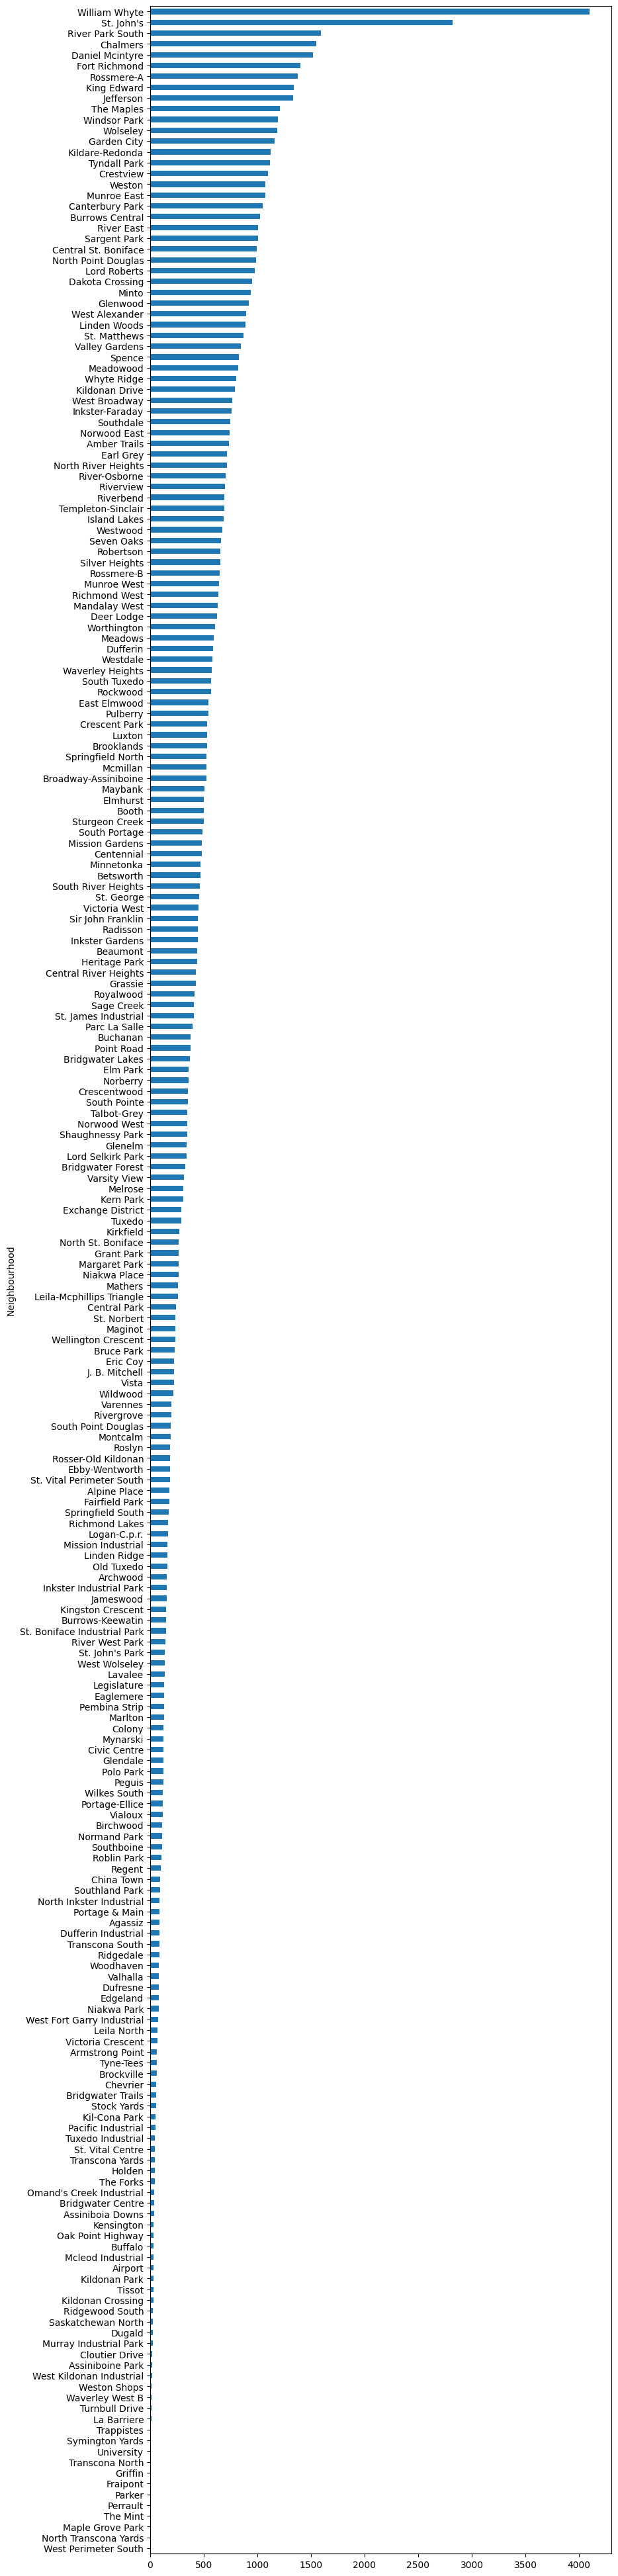

In [5]:
DF.groupby("Neighbourhood").size().sort_values().plot(kind="barh", figsize=(9, 50))

Maybe these downtown hoods are closer to ~~waste station~~? Nope, currently there's only one waste landfill in Winnipeg.  
How about trashtruck's depot?

## Overall Distribution among Requested services

<AxesSubplot: ylabel='Service Request'>

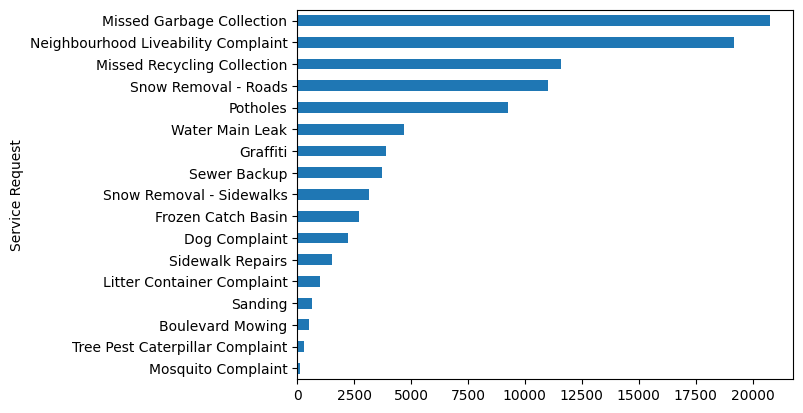

In [6]:
DF.groupby("Service Request").size().sort_values().plot(kind="barh")

# Spatial

### Top 15 Neighborhoods's request

<AxesSubplot: ylabel='Service Request'>

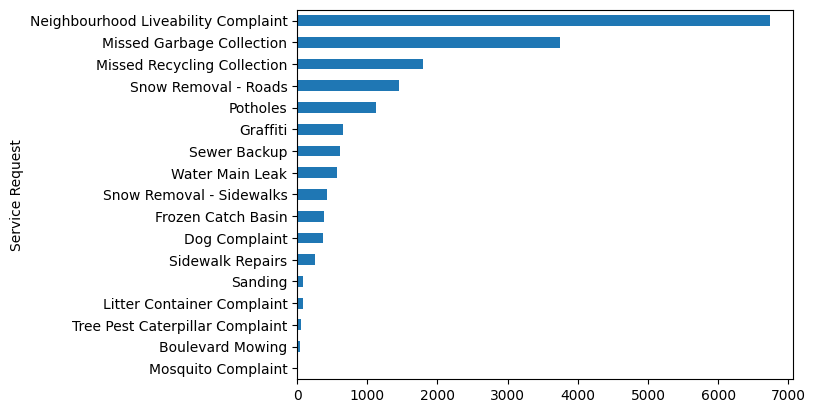

In [7]:
# Bar chart of Service Request for certain neibourhoods
def column_contains(column: str, neighbourhoods: list) -> str:
    ret = ""
    for neighbourhood in neighbourhoods:
        ret += f' or `{column}`.str.contains("{neighbourhood}", regex=False, na=False)'
    return ret[4:]

def top_n(n: int, group_by: str, ascending = False) -> list:
    return [key for key in DF.groupby(group_by).size().sort_values().nlargest(n).to_dict()] if not ascending else [key for key in DF.groupby(group_by).size().sort_values().nsmallest(n).to_dict()]

DF.query(column_contains("Neighbourhood", top_n(10, "Neighbourhood"))).groupby("Service Request").size().sort_values().plot(kind="barh")


# Temporal

### Overall requests by Month

<AxesSubplot: xlabel='Date'>

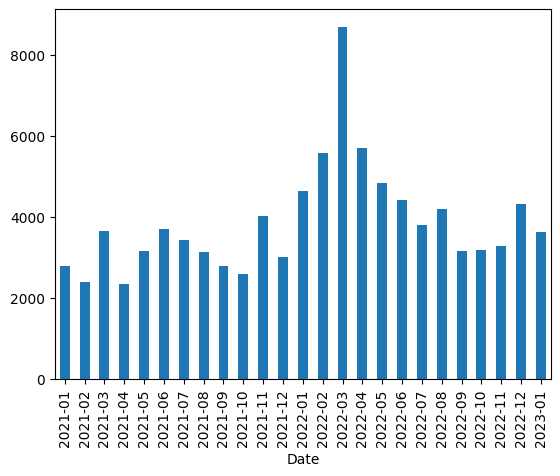

In [8]:
DF.groupby(DF["Date"].dt.to_period("M")).size().plot(kind="bar")

- TODO: We should do proportions in the following graphs instead of raw numbers.
- TODO: separate 2 different kind of graffiti.

### Missed Garbage Collection by month

In [9]:
def service_by_month(index: int):
    pr = pd.period_range(start=DF["Date"].min().strftime('%Y-%m'), end=DF["Date"].max().strftime('%Y-%m'), freq="M")
    pr = pd.Series(data = [0]*len(pr), index=pd.period_range(start="2021-01", end="2023-01", freq="M"))
    return (pr + DF.query(column_contains("Service Request", [services[index]])).groupby(DF["Date"].dt.to_period("M")).size()).fillna(value=0).astype(int).plot(kind="bar", title=services[index])

The data we have here doesn't have anything before the first day of 2021. How unfortunate. 

<AxesSubplot: title={'center': 'Boulevard Mowing'}>

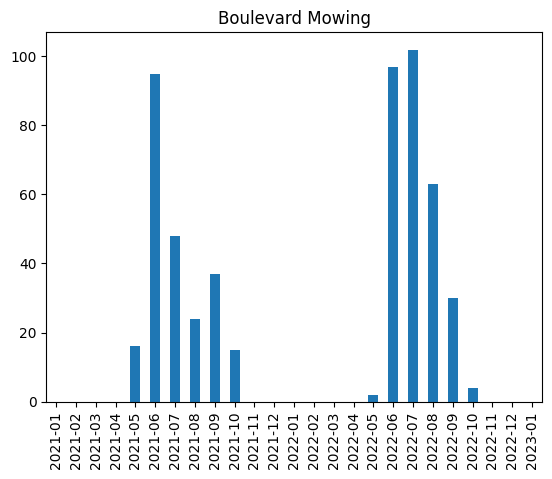

In [10]:
service_by_month(0)

You don't mow grass in winter when there is no grass.

<AxesSubplot: title={'center': 'Dog Complaint'}>

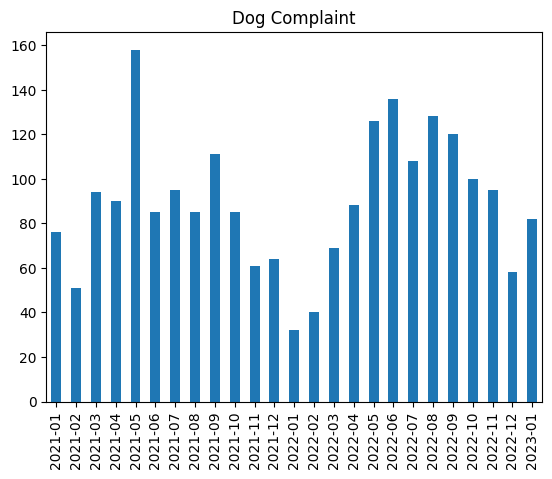

In [11]:
service_by_month(1)

<AxesSubplot: title={'center': 'Frozen Catch Basin'}>

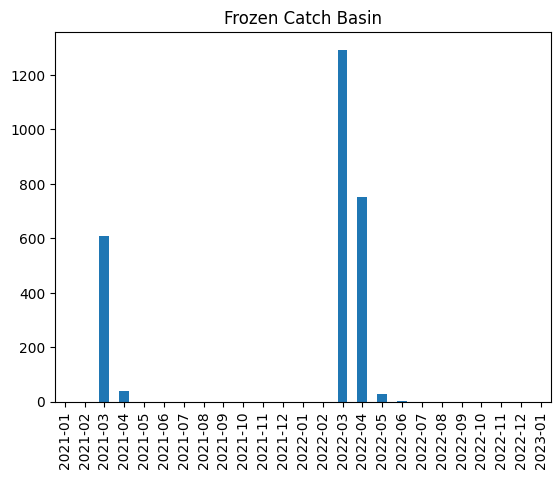

In [12]:
service_by_month(2)

We had a lot of snow last winter, so it's understandable that catch basins are frozen and overwhelmed.

Further verify this by how much cumulative snow we got in the past years

<AxesSubplot: title={'center': 'Graffiti'}>

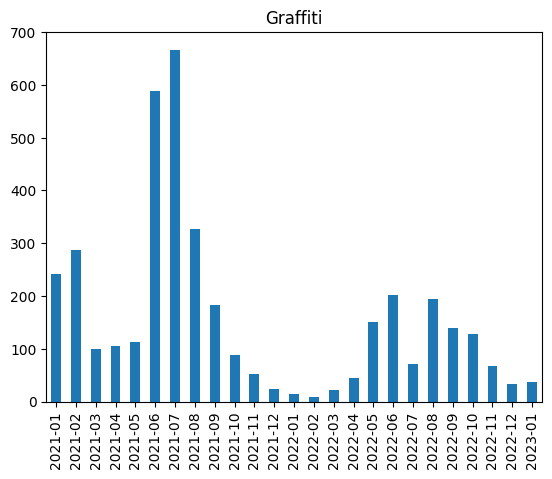

In [13]:
service_by_month(3)

<AxesSubplot: title={'center': 'Graffiti'}>

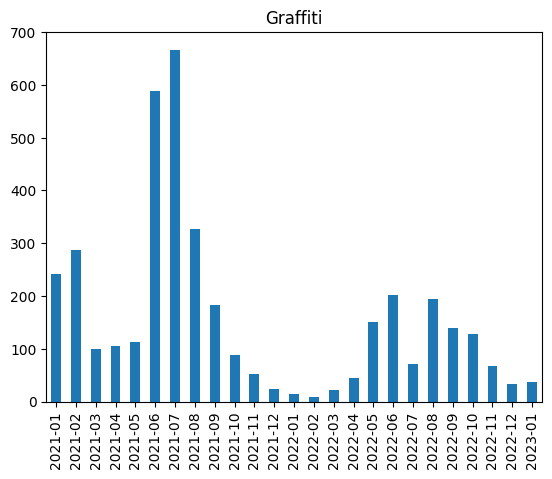

In [14]:
service_by_month(4)

There's a pattern.

People go out in a summer and a comfortable 25C summer night is perfect climate for a graffiti. /s

Nobody want's to do graffiti in -30, right?

But that doesn't explain 2021-01 to 2021-02 why there are so many reports.

maybe useful, need fact check: Crime rate is higher in the winter, lower in the summer.

- What's happening in July 2022?
- What's wrong with Jan/Feb 2021? COVID policy, frustration? 
- COVID waves? Level of hospitalization vs infection(Omicron vs original COVID)

<AxesSubplot: title={'center': 'Litter Container Complaint'}>

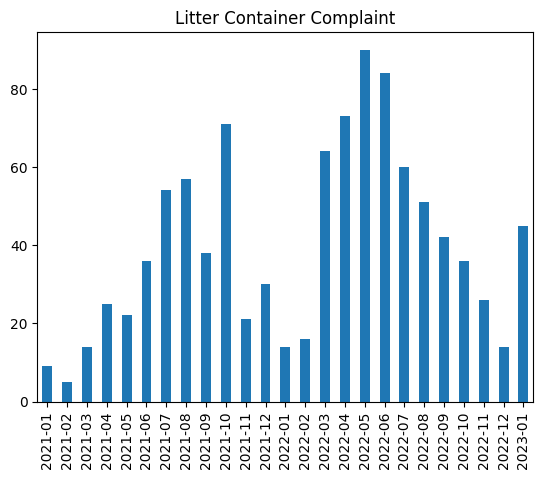

In [15]:
service_by_month(5)

This one matches Carson's hypothesis, garbage smell more in summer, but not in the winter.

<AxesSubplot: title={'center': 'Missed Garbage Collection'}>

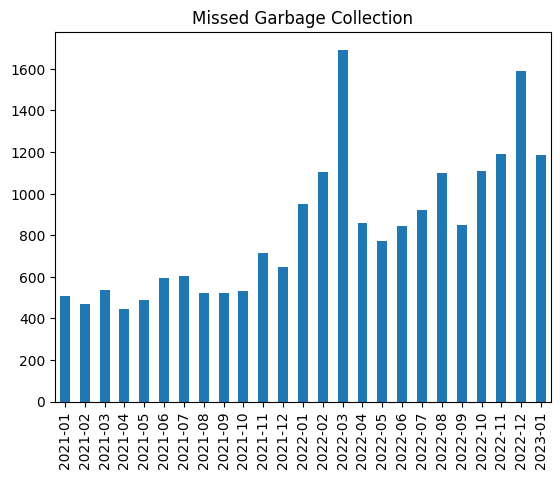

In [16]:
service_by_month(6)

This is interesting.

As discussed with Carson, there maybe more reports on missed garbage collection in summer because it smells, and maybe less on winter because it doesn't smell(people stay inside all of the time, low temps is literally freezing your garbage so nothing could gong bad).

The overall trend is going up. Kind of sad.

But 2 of the peak are in 2022-03 and 2022-12. If you look one year back, from and before 2021-12, the reports are really stable.

Strike?

We need more data to make more out of this, like garbage amounts per month, labour situation, COVID policies, etc.

Residential or industrial, which made more garbage?

<AxesSubplot: title={'center': 'Missed Recycling Collection'}>

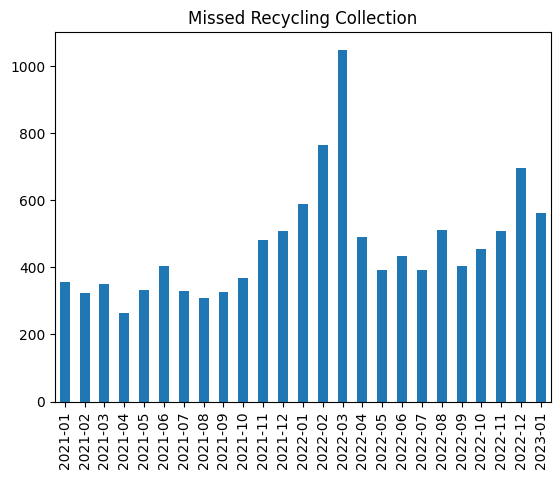

In [17]:
service_by_month(7)

It seems like there's a pattern? COVID is a thing to consider for sure.

<AxesSubplot: title={'center': 'Mosquito Complaint'}>

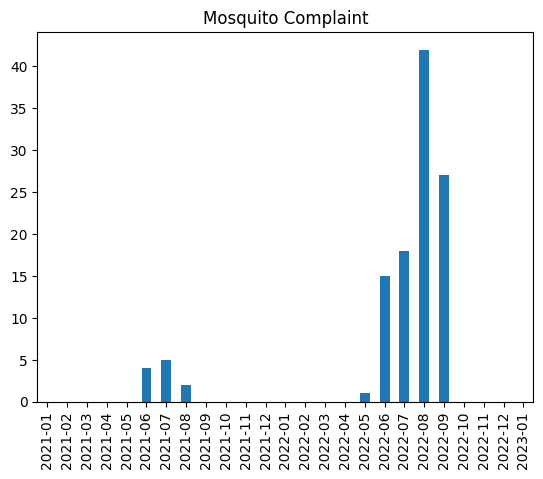

In [18]:
service_by_month(8)

Fuck Mosquitos!

Good thing that mosquito are really sensitive to the temperature. 

But still why 2022 have almost 4x reports than 2021? Does it have something to do with the climate? Or COVID policies?

<AxesSubplot: title={'center': 'Neighbourhood Liveability Complaint'}>

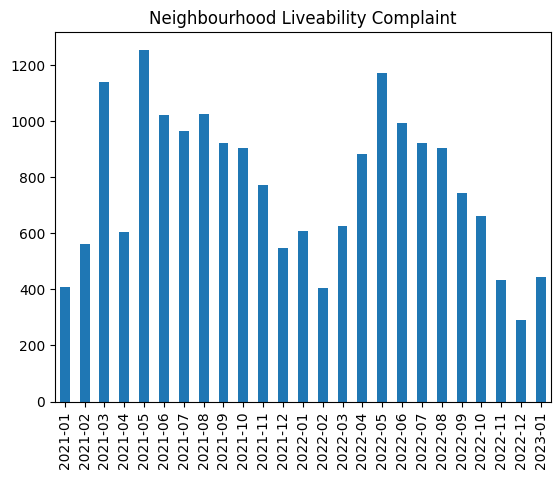

In [19]:
service_by_month(9)

That's a clear pattern, people are more active in the summer.

There was a dip in 2021-04, why? COVID restrictions?

<AxesSubplot: title={'center': 'Potholes'}>

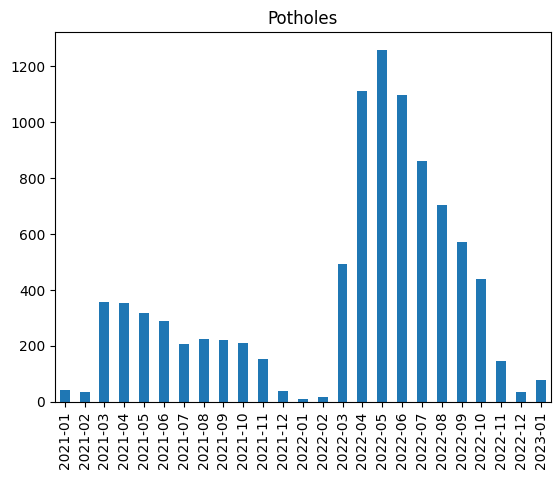

In [20]:
service_by_month(10)

That's a clear pattern, but 2022 was much more dramatic than 2021.

<AxesSubplot: title={'center': 'Sanding'}>

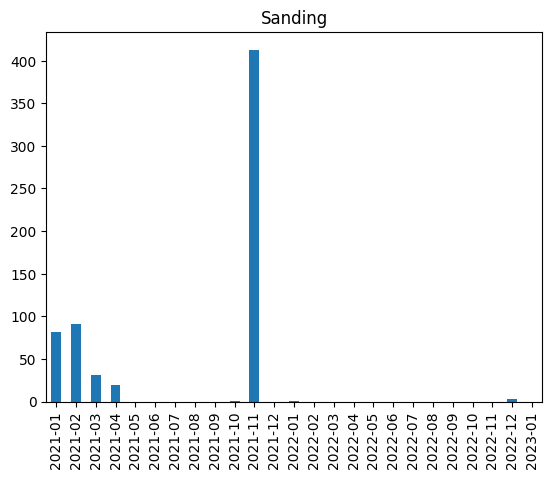

In [21]:
service_by_month(11)

Compare with snow data

<AxesSubplot: title={'center': 'Sewer Backup'}>

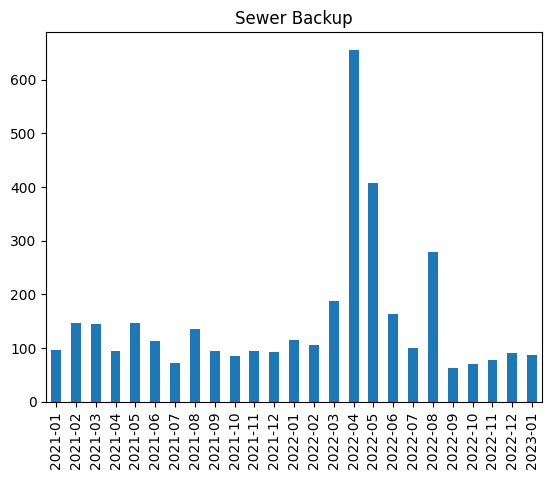

In [22]:
service_by_month(12)

Maybe the water level of Red River have something to do with this?

Probably need some civil engineering help.

<AxesSubplot: title={'center': 'Sidewalk Repairs'}>

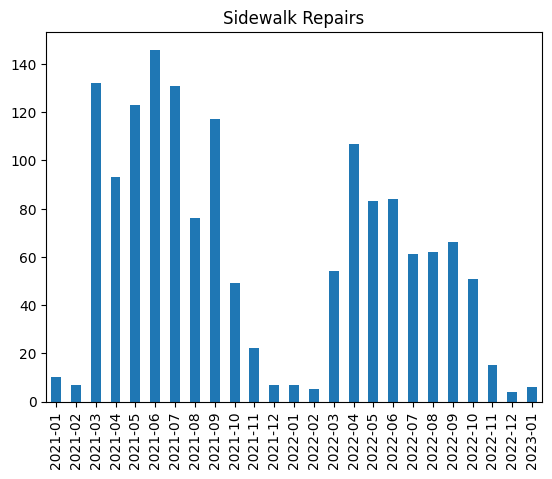

In [23]:
service_by_month(13)

Hmmm that's interesting. As soon as winter come, the reports for sidewalk repairs plummets. I guess that's because nobody wants to walk outside of -30C. Also the snow covers everything, so the snow become the actual road surface.

But there were a lot of snow removal requests for sidewalks. We need to look at where exactly are these snow removal requests originated from. Are they from residential areas? People needs to walk in the neighborhood. Are they from industrial areas like Tuxedo?


<AxesSubplot: title={'center': 'Snow Removal - Roads'}>

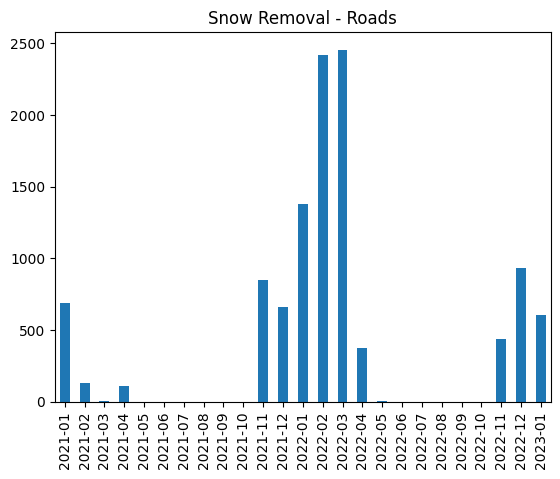

In [24]:
service_by_month(14)

<AxesSubplot: title={'center': 'Snow Removal - Sidewalks'}>

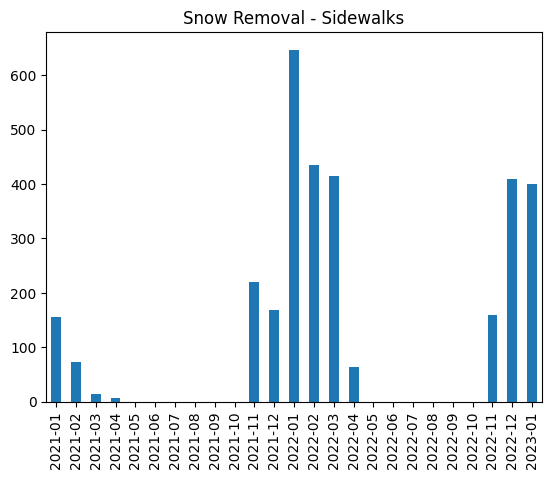

In [25]:
service_by_month(15)

Obviously we don't have snow in the summer, and that's good.

I do remember the Winter of 2021 there were a lot of snows. 

Almost perfect complement with sidewalk repairs

<AxesSubplot: title={'center': 'Tree Pest Caterpillar Complaint'}>

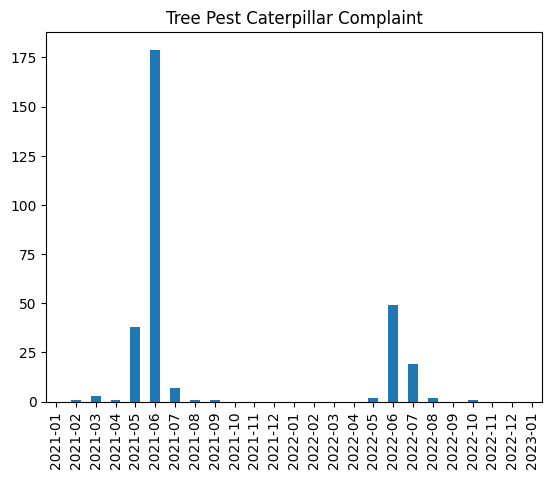

In [26]:
service_by_month(16)

What is this data, they do have a pattern that it's in the summer. There's a big gap between 2021-06 and 2022-06 data.

Note that this is complaint from the Winnipeggers to 311, not the actual work dispatched. If we can have that data, that would explain something, like there were not enough people to work on this, and people are making duplicating requests.

Speaking of duplicate, does all of the data here contains duplications or not?

Because of COVIDin 2021, people are bored and looking for caterpillars.

<AxesSubplot: title={'center': 'Water Main Leak'}>

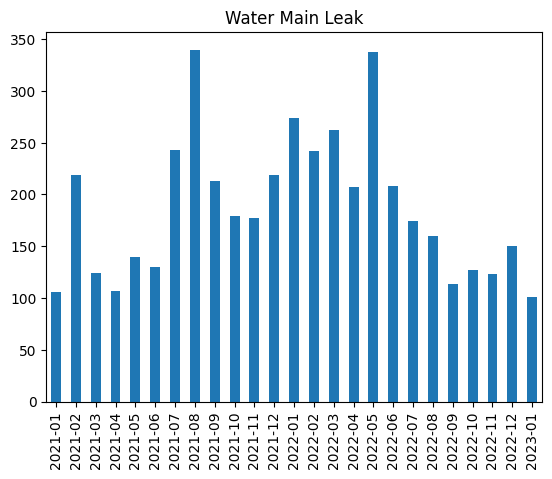

In [27]:
service_by_month(17)

What exactly does this mean?

Maybe the water level of Red River have something to do with this?

I remember one of the summer the water level of red river was really high throughout the whole summer, the sidewalk along the river was completely submerged. That kinds of terrifies me because is that one of the consequences of global warming?

weather and temp related, more in the summer. If that's the case 2021-12 to 2022-03 are odd. Why is that?